Dataset shape: (21613, 3)
      price  square_footage  location
0  221900.0            1180     Rural
1  538000.0            2570  Downtown
2  180000.0             770     Rural
3  604000.0            1960     Rural
4  510000.0            1680  Downtown

Model Performance
MAE: $177,962.97
R^2: 0.494

Predicted price for a 2000 sq ft house in Downtown: $510,963.14

Model Coefficients:
location_Downtown: -6137.0868
location_Rural: 2517.4915
location_Suburb: 3619.5953
square_footage: 279.6215


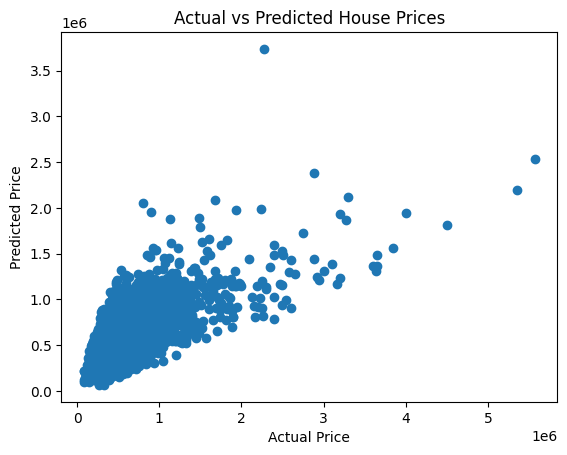


Saved dataset to king_county_price_sqft_location.csv


In [16]:

# ==========================================
# Part 1: House Price Prediction (Linear Regression)
# Dataset: King County House Sales (21,000+ records)
# Source: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction
#
# Assignment note:
# - King County dataset includes price + square footage, but not "Downtown/Suburb/Rural".
# - Per assignment checklist, we add a location column with values:
#   Downtown, Suburb, Rural (randomly generated).
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# ---- 1) Load dataset (upload kc_house_data.csv into Colab first) ----
df = pd.read_csv("/content/kc_house_data.csv")

# ---- 2) Keep only price and square footage ----
df = df[["price", "sqft_living"]].copy()
df.columns = ["price", "square_footage"]
df = df.dropna()

# ---- 3) Add location column (required by rubric) ----
np.random.seed(42)
df["location"] = np.random.choice(["Downtown", "Suburb", "Rural"], size=len(df))

print("Dataset shape:", df.shape)
print(df.head())

# ---- 4) Features and target ----
X = df[["square_footage", "location"]]
y = df["price"]

# ---- 5) Preprocessing: OneHotEncoder for 'location' ----
preprocessor = ColumnTransformer(
    transformers=[
        ("location", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["location"])
    ],
    remainder="passthrough"  # keep square_footage
)

# ---- 6) Pipeline: preprocessing + linear regression ----
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# ---- 7) Train/test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---- 8) Train model ----
model.fit(X_train, y_train)

# ---- 9) Evaluate model ----
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance")
print(f"MAE: ${mae:,.2f}")
print(f"R^2: {r2:.3f}")

# ---- 10) Predict: 2000 sq ft house in Downtown ----
new_house = pd.DataFrame({"square_footage": [2000], "location": ["Downtown"]})
predicted_price = model.predict(new_house)[0]
print(f"\nPredicted price for a 2000 sq ft house in Downtown: ${predicted_price:,.2f}")

# ---- 11) Display model coefficients ----
# Get one-hot feature names for location
ohe = model.named_steps["preprocessor"].named_transformers_["location"]
loc_feature_names = ohe.get_feature_names_out(["location"]).tolist()

# ColumnTransformer puts encoded location columns first, then remainder columns (square_footage)
feature_names = loc_feature_names + ["square_footage"]
coefficients = model.named_steps["regressor"].coef_

print("\nModel Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

# ---- 12) Quick visualization: Actual vs Predicted ----
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.show()

# ---- 13) Save the 3-column dataset (useful for submission evidence) ----
df.to_csv("king_county_price_sqft_location.csv", index=False)
print("\nSaved dataset to king_county_price_sqft_location.csv")

# Part 1: House Price Prediction (Linear Regression)

## Assumptions
- There is a linear relationship between square footage and price.
- Location influences housing prices.
- Other variables (bedrooms, bathrooms, condition) are not included.

## Coefficient Explanation
- The square_footage coefficient represents the average increase in price for each additional square foot.
- The location coefficients show how prices differ for Downtown, Suburb, and Rural compared to the reference location.

## Challenges
- Randomly generated location data may not reflect real-world distribution.
- Real estate prices depend on more features than just square footage and location.

## Potential Improvements
- Add more housing features (bedrooms, bathrooms, zipcode).
- Remove outliers.
- Try Ridge or Lasso regression.

In [17]:
import pandas as pd

df = pd.read_csv("Churn_Modelling.csv")
df.head()
df.shape
df.columns

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ==========================================
# Dataset Source:
# https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling
# 10,000 customers
# ==========================================

# ---- 1) Drop unnecessary columns ----
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

# ---- 2) Define features and target ----
X = df.drop("Exited", axis=1)
y = df["Exited"]

# ---- 3) Identify numeric & categorical features ----
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# ---- 4) Preprocessing ----
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

# ---- 5) Pipeline ----
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=2000))
])

# ---- 6) Train/Test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- 7) Train model ----
model.fit(X_train, y_train)

# ---- 8) Predict probabilities ----
proba = model.predict_proba(X_test)[:, 1]
threshold = 0.5
pred = (proba >= threshold).astype(int)

print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print("ROC-AUC :", round(roc_auc_score(y_test, proba), 4))
print("\nClassification Report:\n", classification_report(y_test, pred))

# ---- 9) Predict for new customer ----
new_customer = pd.DataFrame([{
    "CreditScore": 600,
    "Geography": "France",
    "Gender": "Female",
    "Age": 40,
    "Tenure": 3,
    "Balance": 60000,
    "NumOfProducts": 2,
    "HasCrCard": 1,
    "IsActiveMember": 0,
    "EstimatedSalary": 50000
}])

new_proba = model.predict_proba(new_customer)[0][1]
new_prediction = int(new_proba >= threshold)

print(f"\nChurn Probability: {new_proba:.3f}")
print(f"Churn Prediction (1=churn): {new_prediction}")

Accuracy: 0.808
ROC-AUC : 0.7748

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000


Churn Probability: 0.255
Churn Prediction (1=churn): 0


# Part 2: Customer Churn Interpretation

## Model Performance
The model achieved 80.8% accuracy and a ROC-AUC score of 0.77,
which indicates good predictive performance.

## What the Probability Means
The churn probability represents the likelihood that a customer will leave.
For example, a value of 0.255 means there is a 25.5% chance that the customer will churn.

## Threshold Explanation
We used a threshold of 0.5:
- If probability >= 0.5 → predict churn (1)
- If probability < 0.5 → predict no churn (0)

## Business Application
Businesses can use churn probabilities to:
- Identify high-risk customers
- Offer discounts or incentives
- Provide targeted customer support
- Improve retention strategies

Using features for clustering: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
Rows used for clustering (after dropna): 10000


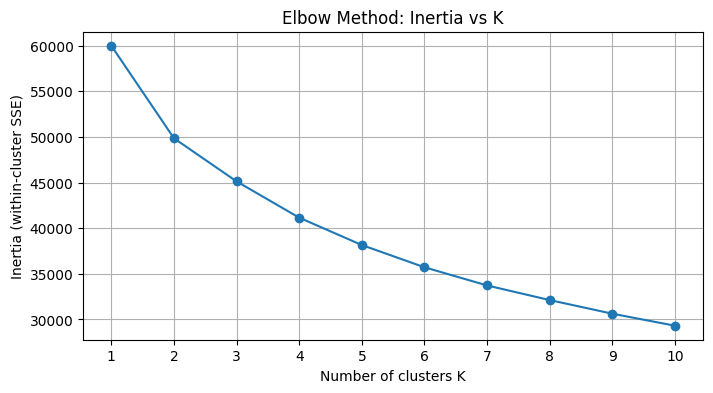

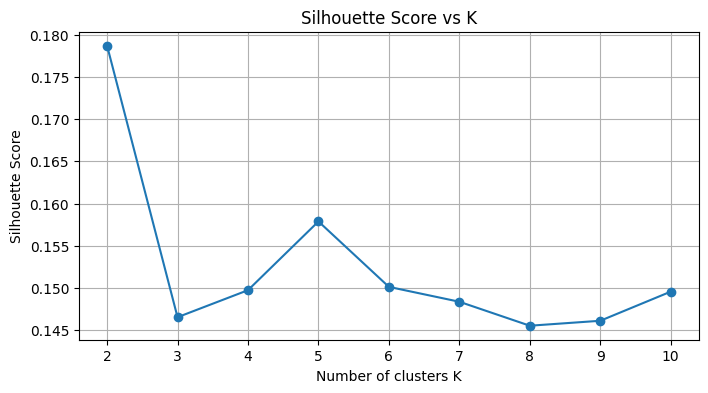

Recommended K (max silhouette): 2

Cluster counts:
 cluster
0    5798
1    4202
Name: count, dtype: int64

Cluster summary (means):
          CreditScore    Age  Tenure    Balance  NumOfProducts  EstimatedSalary
cluster                                                                       
0             651.42  39.12    4.97  123033.82           1.28        100727.33
1             649.30  38.65    5.08   12258.16           1.87         99211.17

Suggested strategies per cluster:

Cluster 0 (n=5798):
- High value customers: Offer premium loyalty programs and personalized wealth-management outreach.

Cluster 1 (n=4202):
- Mid-tier customers: Use standard retention offers and personalized recommendations.

Saved customer segments to: customer_segments.csv
Saved elbow_plot.png and silhouette_plot.png


In [18]:
# ==========================================
# Part 3: Customer Segmentation (K-Means)
# Dataset: Churn_Modelling.csv (Churn dataset you uploaded)
# Goal: create meaningful customer segments and save results
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# ---- 1) Load dataset (make sure file is uploaded) ----
df = pd.read_csv("Churn_Modelling.csv")

# Drop identifier columns if present
for col in ["RowNumber", "CustomerId", "Surname"]:
    if col in df.columns:
        df = df.drop(columns=[col])

# ---- 2) Choose numeric features for segmentation ----
# These are typical customer features suitable for segmentation.
candidate_features = [
    "CreditScore", "Age", "Tenure", "Balance",
    "NumOfProducts", "EstimatedSalary"
]

# Keep only features that actually exist in the file
features = [f for f in candidate_features if f in df.columns]
print("Using features for clustering:", features)

# Ensure there are no missing values for chosen features
seg_df = df[features].copy().dropna()
print("Rows used for clustering (after dropna):", seg_df.shape[0])

# ---- 3) Scale the data ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(seg_df)

# ---- 4) Elbow method (inertia) ----
inertia = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, marker='o')
plt.xticks(K_range)
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method: Inertia vs K")
plt.grid(True)
plt.savefig("elbow_plot.png", bbox_inches="tight")
plt.show()

# ---- 5) Silhouette scores to support K selection ----
sil_scores = []
K_range_sil = range(2, 11)  # silhouette score defined for k>=2
for k in K_range_sil:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8,4))
plt.plot(list(K_range_sil), sil_scores, marker='o')
plt.xticks(list(K_range_sil))
plt.xlabel("Number of clusters K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.grid(True)
plt.savefig("silhouette_plot.png", bbox_inches="tight")
plt.show()

# ---- 6) Choose optimal K ----
# Heuristic: pick K with highest silhouette score (balanced compactness & separation).
best_k = int(K_range_sil[np.argmax(sil_scores)])
print(f"Recommended K (max silhouette): {best_k}")

# If silhouette suggests an overly small/large K you can override,
# but using the silhouette-based K is a good automated heuristic.
optimal_k = best_k

# ---- 7) Fit final KMeans and assign clusters ----
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Attach cluster labels back to original df (align via index after dropna)
seg_df = seg_df.copy()
seg_df['cluster'] = labels
# Create a result DataFrame that joins cluster labels to original customer records
# We'll attach cluster labels to the original df rows corresponding to seg_df indexes
result = df.copy()
result = result.loc[seg_df.index]  # align shape
result = result.assign(cluster=seg_df['cluster'].values)

# ---- 8) Analyze cluster characteristics (means of features) ----
cluster_summary = seg_df.groupby('cluster')[features].mean().round(2)
cluster_counts = seg_df['cluster'].value_counts().sort_index()
print("\nCluster counts:\n", cluster_counts)
print("\nCluster summary (means):\n", cluster_summary)

# ---- 9) Suggest marketing strategies for each cluster ----
print("\nSuggested strategies per cluster:")
for cl in cluster_summary.index:
    row = cluster_summary.loc[cl]
    print(f"\nCluster {cl} (n={cluster_counts.loc[cl]}):")
    # Heuristic rules for suggestions:
    if row['Balance'] >= seg_df['Balance'].quantile(0.66) and row['NumOfProducts'] >= seg_df['NumOfProducts'].median():
        print("- High value customers: Offer premium loyalty programs and personalized wealth-management outreach.")
    elif row['NumOfProducts'] >= seg_df['NumOfProducts'].quantile(0.66) or row['EstimatedSalary'] >= seg_df['EstimatedSalary'].quantile(0.66):
        print("- Upsell opportunity: Cross-sell financial products and tailored bundles.")
    elif row['Tenure'] <= seg_df['Tenure'].quantile(0.33) and row['Balance'] <= seg_df['Balance'].quantile(0.33):
        print("- New / low-value customers: Focus on onboarding, education, and retention campaigns.")
    elif row['Age'] >= seg_df['Age'].quantile(0.66):
        print("- Older customers: Offer stability-focused products and easy-to-use support channels.")
    else:
        print("- Mid-tier customers: Use standard retention offers and personalized recommendations.")

# ---- 10) Save cluster assignments to CSV ----
output_cols = ['cluster'] + features
# Merge cluster labels to original DataFrame (safer: add NaN for rows dropped due to missing)
full_output = df.copy()
full_output['cluster'] = np.nan
full_output.loc[seg_df.index, 'cluster'] = labels
full_output.to_csv("customer_segments.csv", index=False)
print("\nSaved customer segments to: customer_segments.csv")
print("Saved elbow_plot.png and silhouette_plot.png")

# Part 3: Customer Segmentation (K-Means)

## Choosing the Number of Clusters (K)

The elbow method and silhouette score were used to determine the optimal number of clusters.
The silhouette score was highest at K = 2, indicating that two clusters provide the best separation and cohesion.

## Cluster Analysis

### Cluster 0
- Higher average balance (~123,000)
- Fewer products (~1.28)
- Slightly higher estimated salary

This cluster represents high-value customers with large balances.
They may be profitable but not fully cross-sold into multiple products.

### Cluster 1
- Much lower balance (~12,000)
- Higher number of products (~1.87)
- Similar age and salary

This cluster represents mid-tier customers with smaller balances but more products.

## Marketing Strategies

Cluster 0:
- Offer premium loyalty programs
- Provide wealth management services
- Encourage additional product adoption

Cluster 1:
- Offer product bundles
- Provide personalized financial recommendations
- Encourage balance growth through incentives

## Business Impact

Customer segmentation allows the business to:
- Target marketing campaigns more effectively
- Increase cross-selling opportunities
- Improve customer retention strategies